JS Divergence (SMOTE): [0.018010270535027417, 0.010500792989689228, 0.01399863318147594, 0.008956441149975538, 0.012039629723241858, 0.014178121474784894, 0.01647288334981455, 0.010757290325179308, 0.011503819924832789, 0.010320526170504593, 0.00895929094596291, 0.012483420467058103, 0.006514101651874418, 0.017036794682546905, 0.010193795105695153, 0.015251629235856209, 0.008491298531655953, 0.012005330781958413, 0.007790046993791361, 0.00908330030001038, 0.00931647531718802, 0.009454417291995622, 0.012519196379968709, 0.011618119581012349, 0.01710449578361646, 0.010597880412049333, 0.01630329152859862, 0.011467471344528267, 0.01304424287655617, 0.016775857157743986]
JS Divergence (ADASYN): [0.07359470608133004, 0.08030308959258778, 0.11189393375423592, 0.1470505367935364, 0.1333867321974638, 0.11502634778671322, 0.07309060173733463, 0.11570211296325106, 0.10782424480539055, 0.14146379904165027, 0.16061495783747487, 0.15768358720939757, 0.17228249719083494, 0.03724763275411358, 0.15416

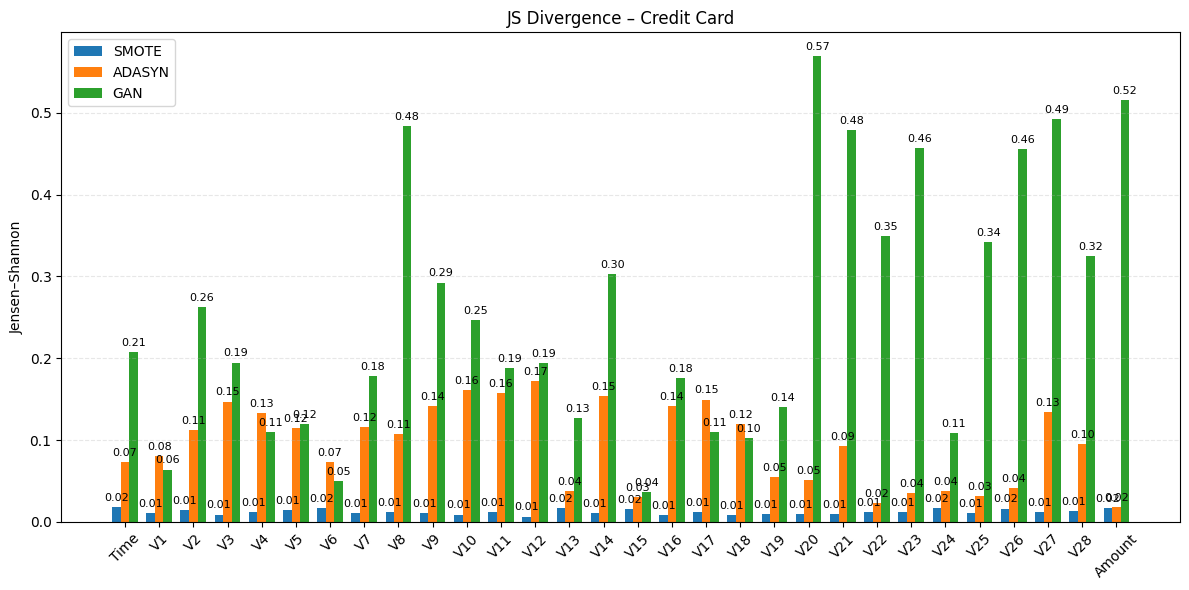

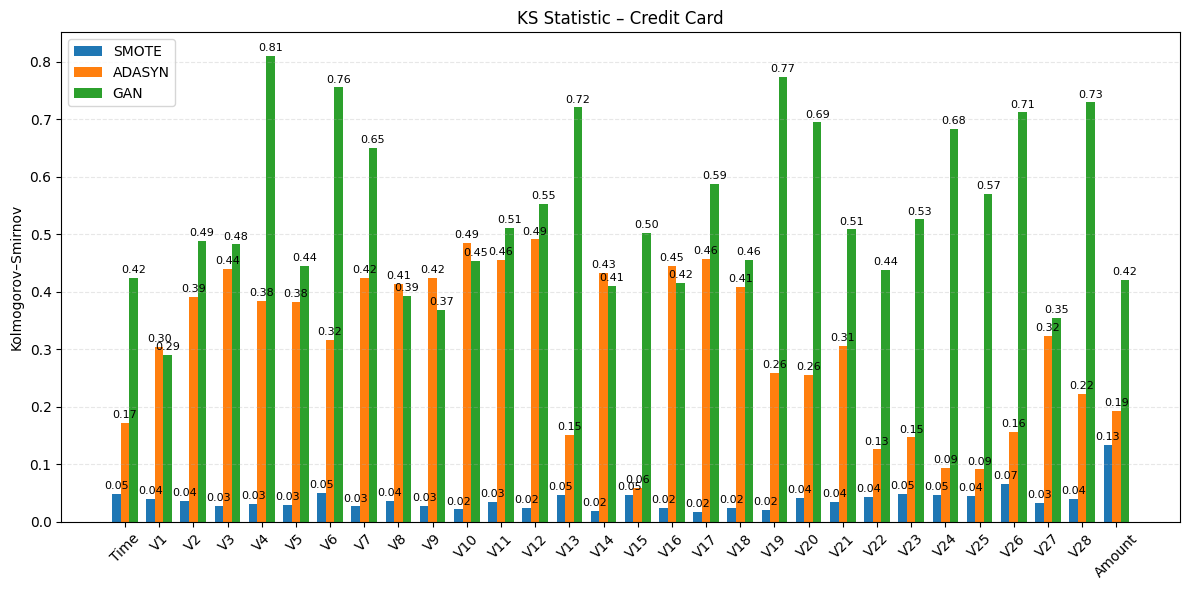

In [4]:
# credit_card_pipeline.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
from scipy.stats import entropy, ks_2samp

# GPU & seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# Generator / Discriminator
class Generator(nn.Module):
    def __init__(self, noise_dim, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 64),  nn.ReLU(),
            nn.Linear(64,         128), nn.ReLU(),
            nn.Linear(128,        input_dim)
        )
    def forward(self, z): return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.LeakyReLU(0.2),
            nn.Linear(128,       64),  nn.LeakyReLU(0.2),
            nn.Linear(64,         1),  nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

def train_gan_on_minority(X_min, noise_dim=16, epochs=200, batch_size=64):
    G = Generator(noise_dim, X_min.shape[1]).to(device)
    D = Discriminator(X_min.shape[1]).to(device)
    opt_G = optim.Adam(G.parameters(), lr=1e-3)
    opt_D = optim.Adam(D.parameters(), lr=1e-3)
    loss_fn = nn.BCELoss()
    loader = DataLoader(TensorDataset(torch.tensor(X_min, dtype=torch.float32)), 
                        batch_size=batch_size, shuffle=True)
    for _ in range(epochs):
        for real, in loader:
            real = real.to(device)
            bs = real.size(0)
            # D step
            noise = torch.randn(bs, noise_dim, device=device)
            fake  = G(noise).detach()
            loss_D = loss_fn(D(real), torch.ones(bs,1,device=device)) + \
                     loss_fn(D(fake), torch.zeros(bs,1,device=device))
            opt_D.zero_grad(); loss_D.backward(); opt_D.step()
            # G step
            noise = torch.randn(bs, noise_dim, device=device)
            fake  = G(noise)
            loss_G = loss_fn(D(fake), torch.ones(bs,1,device=device))
            opt_G.zero_grad(); loss_G.backward(); opt_G.step()
    return G

# Metrics & plotting
def js_divergence(p, q):
    p, q = p/np.sum(p), q/np.sum(q)
    m = 0.5*(p+q)
    return 0.5*(entropy(p, m) + entropy(q, m))

def compute_js_ks(orig_df, synth_df, features):
    js, ks = [], []
    for f in features:
        p = orig_df[f].values
        q = synth_df[f].values
        ph, _ = np.histogram(p, bins=50, density=True)
        qh, _ = np.histogram(q, bins=50, density=True)
        js.append(js_divergence(ph+1e-8, qh+1e-8))
        ks.append(ks_2samp(p, q)[0])
    return js, ks

def plot_metric(vals, title, ylabel, labels):
    x = np.arange(len(labels))
    w = 0.25
    plt.figure(figsize=(12,6))

    bars1 = plt.bar(x - w, vals[0], w, label='SMOTE')
    bars2 = plt.bar(x,     vals[1], w, label='ADASYN')
    bars3 = plt.bar(x + w, vals[2], w, label='GAN')

    # Add value labels
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, 
                     f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    plt.xticks(x, labels, rotation=45)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()


if __name__ == "__main__":
    # 1) Load & preprocess
    df  = pd.read_csv("../data/creditcard.csv")
    X   = df.drop(columns=["Class"]).values
    y   = df["Class"].values
    feats = df.columns[:-1].tolist()

    X_train, _, y_train, _ = train_test_split(
        StandardScaler().fit_transform(X), y,
        stratify=y, test_size=0.3, random_state=42
    )

    # 2) GAN on minority
    X_min = X_train[y_train==1]
    G     = train_gan_on_minority(X_min)
    with torch.no_grad():
        fake = G(torch.randn(len(X_min), 16, device=device)).cpu().numpy()
    gan_df = pd.DataFrame(fake, columns=feats)

    # 3) SMOTE & ADASYN
    sm = SMOTE(k_neighbors=5, random_state=42)
    X_sm, y_sm = sm.fit_resample(X_train, y_train)
    ad = ADASYN(n_neighbors=5, random_state=42)
    X_ad, y_ad = ad.fit_resample(X_train, y_train)

    sm_df = pd.DataFrame(X_sm[y_sm==1], columns=feats)
    ad_df = pd.DataFrame(X_ad[y_ad==1], columns=feats)

    # 4) Metrics & plots for all features
        # 4) Metrics & plots for all features
    orig_df = pd.DataFrame(X_min, columns=feats)
    all_feats = feats

    js_sm, ks_sm = compute_js_ks(orig_df, sm_df, all_feats)
    js_ad, ks_ad = compute_js_ks(orig_df, ad_df, all_feats)
    js_g,  ks_g  = compute_js_ks(orig_df, gan_df, all_feats)

    # Print the lists
    print("JS Divergence (SMOTE):", js_sm)
    print("JS Divergence (ADASYN):", js_ad)
    print("JS Divergence (GAN):", js_g)
    print("KS Statistic (SMOTE):", ks_sm)
    print("KS Statistic (ADASYN):", ks_ad)
    print("KS Statistic (GAN):", ks_g)

    # Plotting
    plot_metric([js_sm, js_ad, js_g], "JS Divergence – Credit Card", "Jensen–Shannon", all_feats)
    plot_metric([ks_sm, ks_ad, ks_g], "KS Statistic – Credit Card", "Kolmogorov–Smirnov", all_feats)

    # Full versions with both classes and labels
    X_sm_full = pd.DataFrame(X_sm, columns=feats)
    X_sm_full["Class"] = y_sm
    X_sm_full.to_csv("../data/full_smote_creditcard.csv", index=False)

    X_ad_full = pd.DataFrame(X_ad, columns=feats)
    X_ad_full["Class"] = y_ad
    X_ad_full.to_csv("../data/full_adasyn_creditcard.csv", index=False)

    gan_full = pd.DataFrame(np.vstack([X_train[y_train==0], fake]), columns=feats)
    gan_full["Class"] = [0]*(X_train[y_train==0].shape[0]) + [1]*len(fake)
    gan_full.to_csv("../data/full_gan_creditcard.csv", index=False)



In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from ctgan import CTGAN
from scipy.spatial.distance import jensenshannon
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# JSD computation with smoothing
def jensen_shannon(p, q, eps=1e-8):
    p += eps; q += eps
    p /= p.sum(); q /= q.sum()
    m = 0.5 * (p + q)
    return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m)))

# Load and preprocess creditcard dataset
df = pd.read_csv("creditcard.csv")
X = df.drop(columns=["Class"])
y = df["Class"]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.3, random_state=42
)

# Extract original fraud samples
X_orig_fraud = X_train[y_train == 1].values

# SMOTE: resample minority class
X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_train, y_train)
X_smote_fraud = X_smote[y_smote == 1]

# ADASYN: resample minority class
X_ada, y_ada = ADASYN(random_state=42).fit_resample(X_train, y_train)
X_ada_fraud = X_ada[y_ada == 1]

# CTGAN: only trained on fraud samples
df_fraud = pd.DataFrame(X_orig_fraud, columns=X_train.columns)
ctgan = CTGAN(epochs=30, batch_size=32, pac=1, verbose=False)
ctgan.fit(df_fraud)
X_gan_fraud = ctgan.sample(len(df_fraud)).values

# Compare with original fraud using JSD and KS
methods = {
    "SMOTE": np.array(X_smote_fraud),
    "ADASYN": np.array(X_ada_fraud),
    "CTGAN": np.array(X_gan_fraud)
}
features = X_train.columns.tolist()
jsd, ks = {m: [] for m in methods}, {m: [] for m in methods}

for i, feat in enumerate(features):
    orig_vals = X_orig_fraud[:, i]
    for name, synth_data in methods.items():
        syn_vals = synth_data[:, i]
        bins = np.histogram_bin_edges(np.concatenate([orig_vals, syn_vals]), bins=100)
        p, _ = np.histogram(orig_vals, bins=bins, density=True)
        q, _ = np.histogram(syn_vals, bins=bins, density=True)
        jsd[name].append(jensen_shannon(p, q))
        ks[name].append(ks_2samp(orig_vals, syn_vals).statistic)

# Plot JSD
plt.figure(figsize=(12, 6))
for name, values in jsd.items():
    plt.plot(features, values, label=name)
plt.title("Jensen–Shannon Divergence: Original Fraud vs. Synthetic")
plt.xlabel("Features")
plt.ylabel("JSD")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Plot KS
plt.figure(figsize=(12, 6))
for name, values in ks.items():
    plt.plot(features, values, label=name)
plt.title("KS Statistic: Original Fraud vs. Synthetic")
plt.xlabel("Features")
plt.ylabel("KS Statistic")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'ctgan'

c:\Users\91623\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\91623\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\91623\anaconda3\envs\tf\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C

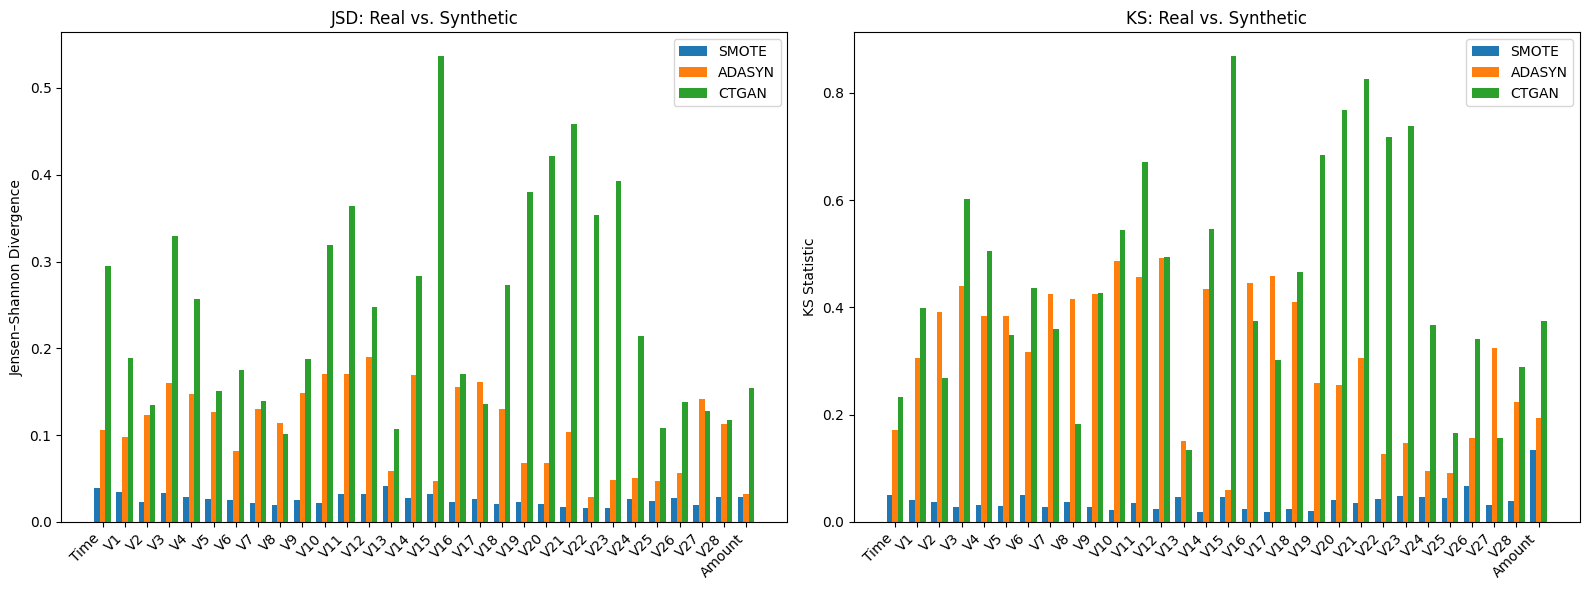

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from ctgan import CTGAN
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Jensen-Shannon Divergence implementation
def jensen_shannon(p, q, eps=1e-8):
    p += eps; q += eps
    p /= p.sum(); q /= q.sum()
    m = 0.5 * (p + q)
    return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m)))

# Load & preprocess creditcard.csv
df = pd.read_csv("creditcard.csv")
X = df.drop(columns=["Class"])
y = df["Class"]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, _, y_train, _ = train_test_split(
    X_scaled, y, stratify=y, test_size=0.3, random_state=42
)

X_orig_fraud = X_train[y_train == 1].values

# SMOTE
X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_train, y_train)
X_smote_fraud = X_smote[y_smote == 1]

# ADASYN
X_ada, y_ada = ADASYN(random_state=42).fit_resample(X_train, y_train)
X_ada_fraud = X_ada[y_ada == 1]

# CTGAN (trained only on fraud)
df_fraud = pd.DataFrame(X_orig_fraud, columns=X.columns)
ctgan = CTGAN(epochs=30, batch_size=32, pac=1, verbose=False)
ctgan.fit(df_fraud)
X_gan_fraud = ctgan.sample(len(df_fraud)).values

# Compute JSD and KS per feature
methods = {
    "SMOTE": np.array(X_smote_fraud),
    "ADASYN": np.array(X_ada_fraud),
    "CTGAN": np.array(X_gan_fraud)
}
features = X.columns.tolist()
jsd, ks = {m: [] for m in methods}, {m: [] for m in methods}

for i, feat in enumerate(features):
    real = X_orig_fraud[:, i]
    for name, synth in methods.items():
        syn = synth[:, i]
        bins = np.histogram_bin_edges(np.concatenate([real, syn]), bins=100)
        p, _ = np.histogram(real, bins=bins, density=True)
        q, _ = np.histogram(syn, bins=bins, density=True)
        jsd[name].append(jensen_shannon(p, q))
        ks[name].append(ks_2samp(real, syn).statistic)

# Plot side-by-side bar charts (JSD + KS)
x = np.arange(len(features))
width = 0.25
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# JSD Bar Plot
axes[0].bar(x - width, jsd["SMOTE"], width, label="SMOTE")
axes[0].bar(x,         jsd["ADASYN"], width, label="ADASYN")
axes[0].bar(x + width, jsd["CTGAN"],  width, label="CTGAN")
axes[0].set_title("JSD: Real vs. Synthetic")
axes[0].set_xticks(x)
axes[0].set_xticklabels(features, rotation=45, ha="right")
axes[0].set_ylabel("Jensen–Shannon Divergence")
axes[0].legend()

# KS Bar Plot
axes[1].bar(x - width, ks["SMOTE"], width, label="SMOTE")
axes[1].bar(x,         ks["ADASYN"], width, label="ADASYN")
axes[1].bar(x + width, ks["CTGAN"],  width, label="CTGAN")
axes[1].set_title("KS: Real vs. Synthetic")
axes[1].set_xticks(x)
axes[1].set_xticklabels(features, rotation=45, ha="right")
axes[1].set_ylabel("KS Statistic")
axes[1].legend()

plt.tight_layout()
plt.show()
